In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/geiot

/content/drive/.shortcut-targets-by-id/1HvjC1Sh_DFmMvqXUWGoYm1lsmbFoWO8K/Colab Notebooks/geiot


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from tqdm import tqdm
from torchvision import models,transforms
from PIL import Image
import cv2
import sys
import json
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import os
import os.path as osp
from glob import glob
import pandas as pd

In [2]:
test_data=pd.read_csv("TeamB/input/test/test_anno.csv", index_col=0)
train_data=pd.read_csv("TeamB/input/train/train_anno.csv", index_col=0)
test_Genki_data=pd.read_csv("TeamB/input/test/test_anno(GENKI).csv", index_col=0).reset_index(drop=True)
train_Genki_data=pd.read_csv("TeamB/input/train/train_anno(GENKI).csv", index_col=0).reset_index(drop=True)
test_MTFL_data=pd.read_csv("TeamB/input/test/test_anno(MTFL).csv", index_col=0).reset_index(drop=True)
train_MTFL_data=pd.read_csv("TeamB/input/train/train_anno(MTFL).csv", index_col=0).reset_index(drop=True)

#test_data[test_data.Label!=5]

In [3]:
test_data=test_data[test_data.Label!=5].reset_index(drop=True)
train_data=train_data[train_data.Label!=5].reset_index(drop=True)
#1:ポジティブ、0:ネガティブ
print(test_data)
dict_map={ 0:0 , 1:0, 2:0 , 3:1 , 6:1 , 4:1}
test_data.Label=test_data.Label.map(dict_map)
train_data.Label=train_data.Label.map(dict_map)


                        imagePath  Label
0     TeamB/KDEF\AF03\AF03NES.JPG      4
1    TeamB/KDEF\BF25\BF25AFFL.JPG      0
2    TeamB/KDEF\AM16\AM16ANFL.JPG      1
3     TeamB/KDEF\BF02\BF02NES.JPG      4
4    TeamB/KDEF\BM18\BM18NEHR.JPG      4
..                            ...    ...
853  TeamB/KDEF\AM04\AM04NEHL.JPG      4
854  TeamB/KDEF\AM12\AM12DIFL.JPG      2
855   TeamB/KDEF\BF28\BF28HAS.JPG      3
856  TeamB/KDEF\BF13\BF13ANHL.JPG      1
857   TeamB/KDEF\AM18\AM18DIS.JPG      2

[858 rows x 2 columns]


#MTFLの成形

In [6]:
train_MTFL_data

,imagePath,Label
0,TeamB/MTFL\lfw_5590/Aaron_Eckhart_0001.jpg,0
1,TeamB/MTFL\lfw_5590/Aaron_Guiel_0001.jpg,1
2,TeamB/MTFL\lfw_5590/Aaron_Peirsol_0001.jpg,1
3,TeamB/MTFL\lfw_5590/Aaron_Pena_0001.jpg,0
4,TeamB/MTFL\lfw_5590/Aaron_Sorkin_0001.jpg,1
...,...,...
9995,TeamB/MTFL\net_7876/_60_929_0.jpg,1
9996,TeamB/MTFL\net_7876/_60_973_0.jpg,0
9997,TeamB/MTFL\net_7876/_60_979_0.jpg,1
9998,TeamB/MTFL\net_7876/_60_980_0.jpg,0


In [5]:
MTFL_dict={2:0,1:1}
train_MTFL_data.Label=train_MTFL_data.Label.map(MTFL_dict)
test_MTFL_data.Label=test_MTFL_data.Label.map(MTFL_dict)

In [7]:
train_data=pd.concat([train_data,train_Genki_data,train_MTFL_data],axis=0).reset_index(drop=True)
test_data=pd.concat([test_data,test_Genki_data,test_MTFL_data],axis=0).reset_index(drop=True)

In [8]:
len(test_data[test_data.Label==0])

2169

In [9]:
len(test_data)

4653

#DataSetクラスの作成

In [10]:
class MyDataset(data.Dataset):
  def __init__(self,dataFrame,transforms):
    """
    初期化
    Param
    ===================
    dataFrame:pd.dataFrame
    画像とアノテーションが含まれているdataFrame
    transforms:
    前処理
    """
    self.dataframe=dataFrame
    self.transforms=transforms
    
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    while (True):
      r_label=self.dataframe.Label[idx]
      img=cv2.imread(self.dataframe.imagePath[idx]) #Image.open(self.img_path[idx])
      if img.shape[2]==1:
        idx=random.randint(0,len(self))
      else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        break
    if self.transforms:
      img=self.transforms(img)

    return img,r_label

# DataLoaderの実装

## 前処理

In [11]:
#TODO:Resizeのサイズ変更
traintransform=transforms.Compose([transforms.ToPILImage(),
                                   transforms.Resize((224,224)),
                                   transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.1),
                                   transforms.RandomPerspective(distortion_scale=0.2, p=0.3,interpolation=transforms.InterpolationMode.NEAREST),
                                   transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1),interpolation=transforms.InterpolationMode.NEAREST),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]
                                   )
testtransform=transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((224,224)),transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [12]:
train_dataset=MyDataset(train_data,transforms=traintransform)

In [13]:
test_dataset=MyDataset(test_data,transforms=testtransform)

In [14]:
ttt=MyDataset(train_MTFL_data,transforms=traintransform)

In [15]:
ttt=data.DataLoader(ttt,batch_size=10,shuffle=True)

## DataLoaderの作成

In [16]:
train_dataLoader=data.DataLoader(train_dataset,batch_size=10,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


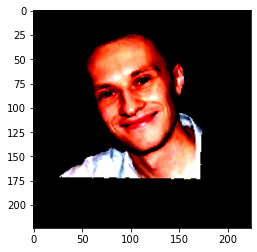

In [20]:
for datas,label in ttt:
  plt.imshow(datas[0].view(-1,224,224).detach().numpy().transpose(1, 2, 0))
  print(label[0])
  break

In [21]:
test_dataLoader=data.DataLoader(test_dataset,batch_size=10,shuffle=False)

# model ダウンロード

In [22]:
#学習済みモデルVGG16をロード

#VGG-16モデルのインスタンスを生成
use_pretrained=True
net=models.vgg16_bn(pretrained=False)
net.load_state_dict(torch.load("TeamB/modelParam/vgg16_bn-6c64b313.pth"))


"""
net=models.resnet18(pretrained=False)
net.load_state_dict(torch.load('modelParam/resnet18-f37072fd.pth'))
"""

"\nnet=models.resnet18(pretrained=False)\nnet.load_state_dict(torch.load('modelParam/resnet18-f37072fd.pth'))\n"

In [23]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [24]:
#モデル追加
save_path='weight_fine_tuning_VGG_2Way_extenddata.pth'
net.classifier.add_module("7",nn.Linear(in_features=1000,out_features=2))
net.train()
#net.add_module("last_fc",nn.Linear(1000,101,bias=False))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [25]:
for name,_ in net.named_parameters():
  print(name)

features.0.weight
features.0.bias
features.1.weight
features.1.bias
features.3.weight
features.3.bias
features.4.weight
features.4.bias
features.7.weight
features.7.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
features.11.weight
features.11.bias
features.14.weight
features.14.bias
features.15.weight
features.15.bias
features.17.weight
features.17.bias
features.18.weight
features.18.bias
features.20.weight
features.20.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.25.weight
features.25.bias
features.27.weight
features.27.bias
features.28.weight
features.28.bias
features.30.weight
features.30.bias
features.31.weight
features.31.bias
features.34.weight
features.34.bias
features.35.weight
features.35.bias
features.37.weight
features.37.bias
features.38.weight
features.38.bias
features.40.weight
features.40.bias
features.41.weight
features.41.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


# 損失関数と最適化手法

In [26]:
criterion=nn.CrossEntropyLoss()

In [27]:
for i in net.parameters():
  print(i.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [28]:
params_to_update_1=[]
params_to_update_2=[]
params_to_update_3=[]
updata_param_names_1=["features"]
updata_param_names_2=["classifier.0.weight","classifier.0.bias","classifier.3.weight","classifier.3.bias","classifier.6.weight","classifier.6.bias"]
updata_param_names_3=["classifier.7.weight","classifier.7.bias"]
for name,param in net.named_parameters():
  if updata_param_names_1[0] in name:
    param.requires_grad=True
    params_to_update_1.append(param)
    print("params_to_update_１に格納：",name)
  elif name in updata_param_names_2:
    param.requires_grad=True
    params_to_update_2.append(param)
    print("param_to_update_2に格納：",name)
  elif name in updata_param_names_3:
    param.requires_grad=True
    params_to_update_3.append(param)
    print("param_to_update_3に格納:",name)
  else:
    param.requires_grad=False
    print("勾配計算なし。学習しない雑魚：",name)
  

params_to_update_１に格納： features.0.weight
params_to_update_１に格納： features.0.bias
params_to_update_１に格納： features.1.weight
params_to_update_１に格納： features.1.bias
params_to_update_１に格納： features.3.weight
params_to_update_１に格納： features.3.bias
params_to_update_１に格納： features.4.weight
params_to_update_１に格納： features.4.bias
params_to_update_１に格納： features.7.weight
params_to_update_１に格納： features.7.bias
params_to_update_１に格納： features.8.weight
params_to_update_１に格納： features.8.bias
params_to_update_１に格納： features.10.weight
params_to_update_１に格納： features.10.bias
params_to_update_１に格納： features.11.weight
params_to_update_１に格納： features.11.bias
params_to_update_１に格納： features.14.weight
params_to_update_１に格納： features.14.bias
params_to_update_１に格納： features.15.weight
params_to_update_１に格納： features.15.bias
params_to_update_１に格納： features.17.weight
params_to_update_１に格納： features.17.bias
params_to_update_１に格納： features.18.weight
params_to_update_１に格納： features.18.bias
params_to_update_１に格納： featu

In [29]:
#このようにして配列に挿入した辞書函数使って、モデルパラメータごとにオプティマイザーのパラメーターを設定することができる
optimizer=optim.Adam([{'params':params_to_update_1,'lr':1e-4},
                      {'params':params_to_update_2,'lr':5e-4},
                      {'params':params_to_update_3,'lr':1e-3}])
#optimizer=optim.Adam(net.parameters(),lr=0.001)

In [30]:
def tarin_model(net,dataloaders_dict,criterion,optimizer,num_epochs):
  #初期設定
  #GPUが使えるかを確認する
  device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print('使用でヴァイス:',device)
  #ネットワークをGPUへ
  net=net.to(device)
  #ネットワークがある程度固定(epochごとにネットワーク構造や損失関数が変わったりしない)の場合に高速化させる
  torch.backends.cudnn.benchmark=True
  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1,num_epochs))
    print('__________')
    for phase in ['train','test']:
      if phase=='train':
        net.train()
      else:
        net.eval()
      epoch_loss=0.0
      epoch_corrects=0
      for inputs,labels in tqdm(data_loaders_dict[phase]):
        #入力をGPUへ
        inputs=inputs.to(device)
        labels=labels.to(device)
        #optimizerの初期化
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase=='train'):
          outputs=net(inputs)
          #print("output",outputs.shape)
          #print("labels",torch.max(labels,1)[1])
          loss=criterion(outputs,labels)
          _,preds=torch.max(outputs,1)
          if phase=='train':
            loss.backward()
            optimizer.step()
          #tensor.item()はTensor内部の数値をPythonの数字で出力.戻り値はintやfloat
          epoch_loss+=loss.item()*inputs.size(0)
          #Tensor.dataはTensorのコピーを作成する。戻り値もTensor
          epoch_corrects+=torch.sum(preds==labels.data)
      epoch_loss=epoch_loss/len(data_loaders_dict[phase].dataset)
      epoch_acc=epoch_corrects.double()/len(data_loaders_dict[phase].dataset)
      net=net.to("cpu")
      torch.save(net.state_dict(),save_path)
      net=net.to(device)
      print('{} Loss: {:4f} Acc: {:4f}'.format(phase,epoch_loss,epoch_acc))
      print("output",outputs.shape)

In [31]:
data_loaders_dict={"train":train_dataLoader,"test":test_dataLoader}

In [33]:
num=50
tarin_model(net,data_loaders_dict,criterion,optimizer,num_epochs=num)

使用でヴァイス: cuda
Epoch 1/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:07<00:00,  3.88it/s]


train Loss: 0.228558 Acc: 0.904843
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:47<00:00,  9.74it/s]


test Loss: 0.379068 Acc: 0.829357
output torch.Size([3, 2])
Epoch 2/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [05:54<00:00,  4.67it/s]


train Loss: 0.209421 Acc: 0.916329
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:37<00:00, 12.35it/s]


test Loss: 0.365010 Acc: 0.838169
output torch.Size([3, 2])
Epoch 3/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:33<00:00,  4.21it/s]


train Loss: 0.213832 Acc: 0.915422
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:46<00:00, 10.08it/s]


test Loss: 0.355994 Acc: 0.856437
output torch.Size([3, 2])
Epoch 4/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:12<00:00,  3.82it/s]


train Loss: 0.192408 Acc: 0.924974
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:48<00:00,  9.57it/s]


test Loss: 0.581309 Acc: 0.781431
output torch.Size([3, 2])
Epoch 5/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:24<00:00,  3.72it/s]


train Loss: 0.189626 Acc: 0.926304
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:48<00:00,  9.61it/s]


test Loss: 0.346244 Acc: 0.846551
output torch.Size([3, 2])
Epoch 6/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:15<00:00,  3.80it/s]


train Loss: 0.173625 Acc: 0.932169
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:48<00:00,  9.68it/s]


test Loss: 0.373758 Acc: 0.844616
output torch.Size([3, 2])
Epoch 7/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:11<00:00,  3.84it/s]


train Loss: 0.165635 Acc: 0.935312
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:45<00:00, 10.15it/s]


test Loss: 0.527685 Acc: 0.828498
output torch.Size([3, 2])
Epoch 8/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:00<00:00,  3.93it/s]


train Loss: 0.164432 Acc: 0.936945
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:52<00:00,  8.84it/s]


test Loss: 0.401362 Acc: 0.852568
output torch.Size([3, 2])
Epoch 9/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:21<00:00,  3.75it/s]


train Loss: 0.155251 Acc: 0.941660
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:48<00:00,  9.51it/s]


test Loss: 0.427820 Acc: 0.845046
output torch.Size([3, 2])
Epoch 10/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:33<00:00,  3.65it/s]


train Loss: 0.147949 Acc: 0.940572
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:50<00:00,  9.26it/s]


test Loss: 0.545898 Acc: 0.834300
output torch.Size([3, 2])
Epoch 11/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:28<00:00,  3.69it/s]


train Loss: 0.128986 Acc: 0.950849
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:49<00:00,  9.46it/s]


test Loss: 0.576445 Acc: 0.842897
output torch.Size([3, 2])
Epoch 12/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:12<00:00,  3.83it/s]


train Loss: 0.133758 Acc: 0.949157
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:48<00:00,  9.65it/s]


test Loss: 0.476910 Acc: 0.831077
output torch.Size([3, 2])
Epoch 13/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:24<00:00,  3.72it/s]


train Loss: 0.133135 Acc: 0.952179
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:47<00:00,  9.71it/s]


test Loss: 0.841666 Acc: 0.810445
output torch.Size([3, 2])
Epoch 14/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:19<00:00,  3.77it/s]


train Loss: 0.130791 Acc: 0.950426
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:49<00:00,  9.34it/s]


test Loss: 0.917875 Acc: 0.775844
output torch.Size([3, 2])
Epoch 15/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:11<00:00,  3.83it/s]


train Loss: 0.114927 Acc: 0.957560
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:54<00:00,  8.58it/s]


test Loss: 0.629137 Acc: 0.838814
output torch.Size([3, 2])
Epoch 16/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:20<00:00,  4.35it/s]


train Loss: 0.121080 Acc: 0.954356
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:42<00:00, 10.93it/s]


test Loss: 0.458067 Acc: 0.844187
output torch.Size([3, 2])
Epoch 17/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:18<00:00,  3.77it/s]


train Loss: 0.108906 Acc: 0.958830
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:52<00:00,  8.84it/s]


test Loss: 0.562406 Acc: 0.845261
output torch.Size([3, 2])
Epoch 18/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:16<00:00,  3.79it/s]


train Loss: 0.110868 Acc: 0.958588
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:50<00:00,  9.20it/s]


test Loss: 0.587674 Acc: 0.850634
output torch.Size([3, 2])
Epoch 19/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:17<00:00,  3.78it/s]


train Loss: 0.107950 Acc: 0.959918
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:51<00:00,  8.97it/s]


test Loss: 0.484782 Acc: 0.853643
output torch.Size([3, 2])
Epoch 20/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:58<00:00,  3.96it/s]


train Loss: 0.098623 Acc: 0.961792
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:38<00:00, 12.15it/s]


test Loss: 0.392460 Acc: 0.842037
output torch.Size([3, 2])
Epoch 21/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:53<00:00,  4.00it/s]


train Loss: 0.114121 Acc: 0.958225
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:38<00:00, 12.13it/s]


test Loss: 0.762636 Acc: 0.819901
output torch.Size([3, 2])
Epoch 22/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [05:51<00:00,  4.71it/s]


train Loss: 0.094200 Acc: 0.966870
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:37<00:00, 12.50it/s]


test Loss: 0.785172 Acc: 0.844187
output torch.Size([3, 2])
Epoch 23/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [05:51<00:00,  4.71it/s]


train Loss: 0.107076 Acc: 0.961671
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:37<00:00, 12.42it/s]


test Loss: 0.610210 Acc: 0.832581
output torch.Size([3, 2])
Epoch 24/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [05:50<00:00,  4.72it/s]


train Loss: 0.097914 Acc: 0.965359
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:37<00:00, 12.50it/s]


test Loss: 0.544920 Acc: 0.850204
output torch.Size([3, 2])
Epoch 25/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:09<00:00,  4.48it/s]


train Loss: 0.087154 Acc: 0.967717
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:44<00:00, 10.38it/s]


test Loss: 0.554964 Acc: 0.843112
output torch.Size([3, 2])
Epoch 26/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:28<00:00,  4.26it/s]


train Loss: 0.094926 Acc: 0.967898
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:51<00:00,  9.09it/s]


test Loss: 0.499195 Acc: 0.851064
output torch.Size([3, 2])
Epoch 27/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:24<00:00,  3.73it/s]


train Loss: 0.084795 Acc: 0.969530
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:49<00:00,  9.49it/s]


test Loss: 0.562691 Acc: 0.839029
output torch.Size([3, 2])
Epoch 28/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:47<00:00,  3.54it/s]


train Loss: 0.085630 Acc: 0.969833
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:54<00:00,  8.53it/s]


test Loss: 0.510128 Acc: 0.844187
output torch.Size([3, 2])
Epoch 29/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:22<00:00,  3.74it/s]


train Loss: 0.086094 Acc: 0.971283
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:48<00:00,  9.66it/s]


test Loss: 0.506213 Acc: 0.840103
output torch.Size([3, 2])
Epoch 30/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:33<00:00,  4.21it/s]


train Loss: 0.090703 Acc: 0.968382
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:37<00:00, 12.37it/s]


test Loss: 0.489315 Acc: 0.831936
output torch.Size([3, 2])
Epoch 31/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:50<00:00,  4.03it/s]


train Loss: 0.086024 Acc: 0.970195
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:44<00:00, 10.42it/s]


test Loss: 0.485242 Acc: 0.843327
output torch.Size([3, 2])
Epoch 32/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:52<00:00,  4.01it/s]


train Loss: 0.075018 Acc: 0.972855
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:44<00:00, 10.43it/s]


test Loss: 0.645518 Acc: 0.823770
output torch.Size([3, 2])
Epoch 33/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:13<00:00,  3.82it/s]


train Loss: 0.079195 Acc: 0.972916
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:47<00:00,  9.75it/s]


test Loss: 1.189335 Acc: 0.830862
output torch.Size([3, 2])
Epoch 34/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:10<00:00,  3.85it/s]


train Loss: 0.075190 Acc: 0.973158
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:50<00:00,  9.28it/s]


test Loss: 0.856142 Acc: 0.832796
output torch.Size([3, 2])
Epoch 35/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:08<00:00,  3.86it/s]


train Loss: 0.078784 Acc: 0.973883
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:46<00:00, 10.11it/s]


test Loss: 0.877067 Acc: 0.827208
output torch.Size([3, 2])
Epoch 36/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:08<00:00,  3.86it/s]


train Loss: 0.088259 Acc: 0.969953
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:50<00:00,  9.25it/s]


test Loss: 0.750319 Acc: 0.839888
output torch.Size([3, 2])
Epoch 37/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:05<00:00,  3.89it/s]


train Loss: 0.068886 Acc: 0.976180
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:45<00:00, 10.18it/s]


test Loss: 0.684980 Acc: 0.804212
output torch.Size([3, 2])
Epoch 38/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:05<00:00,  3.89it/s]


train Loss: 0.071074 Acc: 0.975757
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:44<00:00, 10.39it/s]


test Loss: 0.795103 Acc: 0.838599
output torch.Size([3, 2])
Epoch 39/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:09<00:00,  3.85it/s]


train Loss: 0.063944 Acc: 0.977813
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:46<00:00,  9.98it/s]


test Loss: 0.746560 Acc: 0.832796
output torch.Size([3, 2])
Epoch 40/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:08<00:00,  3.86it/s]


train Loss: 0.066929 Acc: 0.977934
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:48<00:00,  9.65it/s]


test Loss: 0.807295 Acc: 0.851279
output torch.Size([3, 2])
Epoch 41/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:08<00:00,  3.87it/s]


train Loss: 0.067228 Acc: 0.976362
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:49<00:00,  9.50it/s]


test Loss: 0.770364 Acc: 0.831292
output torch.Size([3, 2])
Epoch 42/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:04<00:00,  3.90it/s]


train Loss: 0.074359 Acc: 0.974911
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:52<00:00,  8.81it/s]


test Loss: 1.148124 Acc: 0.832151
output torch.Size([3, 2])
Epoch 43/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:50<00:00,  4.03it/s]


train Loss: 0.063874 Acc: 0.978055
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:46<00:00,  9.95it/s]


test Loss: 0.752228 Acc: 0.842252
output torch.Size([3, 2])
Epoch 44/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:20<00:00,  3.76it/s]


train Loss: 0.061628 Acc: 0.979687
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:47<00:00,  9.75it/s]


test Loss: 0.731862 Acc: 0.816892
output torch.Size([3, 2])
Epoch 45/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:21<00:00,  3.75it/s]


train Loss: 0.069080 Acc: 0.976543
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:47<00:00,  9.73it/s]


test Loss: 0.496742 Acc: 0.847625
output torch.Size([3, 2])
Epoch 46/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:14<00:00,  3.81it/s]


train Loss: 0.061056 Acc: 0.979808
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:50<00:00,  9.22it/s]


test Loss: 0.981792 Acc: 0.849559
output torch.Size([3, 2])
Epoch 47/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:10<00:00,  3.85it/s]


train Loss: 0.060366 Acc: 0.978417
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:48<00:00,  9.57it/s]


test Loss: 0.982917 Acc: 0.847840
output torch.Size([3, 2])
Epoch 48/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [07:24<00:00,  3.72it/s]


train Loss: 0.070167 Acc: 0.976483
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:48<00:00,  9.63it/s]


test Loss: 0.638408 Acc: 0.813239
output torch.Size([3, 2])
Epoch 49/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [06:07<00:00,  4.50it/s]


train Loss: 0.059044 Acc: 0.979989
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:37<00:00, 12.31it/s]


test Loss: 0.641714 Acc: 0.831292
output torch.Size([3, 2])
Epoch 50/50
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [05:52<00:00,  4.69it/s]


train Loss: 0.053110 Acc: 0.980956
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:37<00:00, 12.40it/s]


test Loss: 0.925751 Acc: 0.841393
output torch.Size([3, 2])


In [ ]:
dat

NameError: ignored